In [0]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

Using TensorFlow backend.


**Load of DataSet Data is divided in:**

Training set (80%)
Validation set (20%)
Testing set

The label classes in the dataset are:

airplane,
automobile,
bird,
cat,
deer,
dog,
frog,
horse,
ship,
truck, 

In [0]:
import numpy as np
import keras
from matplotlib import pyplot
from PIL import Image
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split



In [0]:

def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(Image.fromarray(X[k]))
            k = k+1
    # show the plot
    pyplot.show()

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate




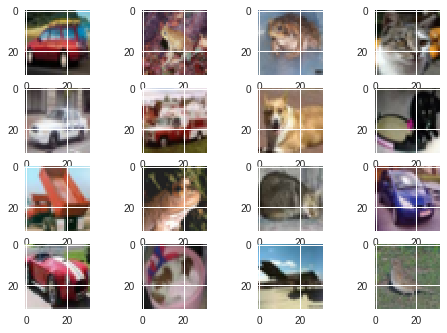

Training Set:80.0
Validation Set:20.0


In [0]:
# Load the data
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
x_c= np.concatenate((X_train,X_test),axis=0)
y_c= np.concatenate((Y_train,Y_test),axis=0)

x_train, x_test, y_train, y_test = train_test_split(x_c, y_c,
                                                    test_size=0.2, 
                                                    random_state=1)
show_imgs(x_test[:16])

print("Training Set:" + str(x_train.shape[0]*100/(x_train.shape[0]+x_test.shape[0])))
print("Validation Set:" + str(x_test.shape[0]*100/(x_train.shape[0]+x_test.shape[0])))

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')   


#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)


num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)



# Simple hold-out validation

## Data augmentation

First,  it's created a "model_1", which contains 4 convolutional layers, a kernel of size (3,3) and maxpooling of size(2,2). Then the model_1 is evaluated with and without using data augmentation.

In [0]:
weight_decay = 1e-4

## model_1
#Conv Layer 1
model_1 = Sequential()
model_1.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model_1.add(Activation('elu'))

#Conv Layer 2
model_1.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model_1.add(Activation('elu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))
 
model_1.add(Flatten())
model_1.add(Dense(num_classes, activation='softmax'))

print("model_1 summary")
model_1.summary()

Instructions for updating:
Colocations handled automatically by placer.
model_1 summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
______________________________________________________

In [0]:
#Training
batch_size = 10
epochs = 10
epoch_size=100
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

model_1.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history = model_1.fit(x_train, 
                      y_train,
                      validation_split=0.2, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      verbose=0) 

#Evaluate
scores_1 = model_1.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)



#Data augmentation
datagen_2 = ImageDataGenerator()
datagen_2.fit(x_train)

#Training
#model_1 with data augmentation
model_1.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model_1.fit_generator(datagen_2.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=epochs*epoch_size // batch_size,epochs=epochs,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

#Evaluate
scores_2 = model_1.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

print('\nTest without data augmentation: %.3f loss: %.3f' % (scores_1[1]*100,scores_1[0]))
print('\nTest  with data augmentation: %.3f loss: %.3f' % (scores_2[1]*100,scores_2[0]))

Instructions for updating:
Use tf.cast instead.
12000/12000 [==============================] - 3s 226us/step
Epoch 1/10
100/100 [==============================] - 3s 33ms/step - loss: 0.8545 - acc: 0.7360 - val_loss: 1.4890 - val_acc: 0.5989
Epoch 2/10
100/100 [==============================] - 3s 31ms/step - loss: 0.7948 - acc: 0.7630 - val_loss: 1.5720 - val_acc: 0.5873
Epoch 3/10
100/100 [==============================] - 3s 31ms/step - loss: 0.8052 - acc: 0.7600 - val_loss: 1.5347 - val_acc: 0.5902
Epoch 4/10
100/100 [==============================] - 3s 31ms/step - loss: 0.8139 - acc: 0.7490 - val_loss: 1.5056 - val_acc: 0.5892
Epoch 5/10
100/100 [==============================] - 3s 31ms/step - loss: 0.8060 - acc: 0.7620 - val_loss: 1.5888 - val_acc: 0.5803
Epoch 6/10
100/100 [==============================] - 3s 31ms/step - loss: 0.7915 - acc: 0.7600 - val_loss: 1.5893 - val_acc: 0.5825
Epoch 7/10
100/100 [==============================] - 3s 31ms/step - loss: 0.8285 - acc: 0.75

## Dropout 

The following two models contain 2 convolutional layers, a kernel of size (3,3); maxpooling of size(2,2) and a data augmentation. The difference between the two models is:

*   model_2: dropout rate=0.2
*   model_3: dropout rate=0.5

In [0]:
## model_2 -> without dropout
#Conv Layer 1
model_2 = Sequential()
model_2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model_2.add(Activation('elu'))

#Conv Layer 2
model_2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model_2.add(Activation('elu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Dropout(0.2))


model_2.add(Flatten())
model_2.add(Dense(num_classes, activation='softmax'))

print("\nmodel_2 summary:")
model_2.summary()

## model_3 -> with dropout
#Conv Layer 1
model_3 = Sequential()
model_3.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model_3.add(Activation('elu'))

#Conv Layer 2
model_3.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model_3.add(Activation('elu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.5))

model_3.add(Flatten())
model_3.add(Dense(num_classes, activation='softmax'))

print("\nmodel_3 summary:")
model_3.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

model_2 summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________

In [0]:
#Training
batch_size = 10
epochs = 10
epoch_size=100
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

#model_2 without dropout
model_2.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model_2.fit_generator(datagen_2.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=epochs*epoch_size // batch_size,epochs=epochs,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

#Evaluate
scores_3 = model_2.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)



#Training
#model_3 with dropout
model_3.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model_3.fit_generator(datagen_2.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=epochs*epoch_size // batch_size,epochs=epochs,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

#Evaluate
scores_4 = model_3.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

print('\nTest dropout 0.2: %.3f loss: %.3f' % (scores_3[1]*100,scores_3[0]))
print('\nTest dropout 0.5: %.3f loss: %.3f' % (scores_4[1]*100,scores_4[0]))


Epoch 1/10
100/100 [==============================] - 4s 35ms/step - loss: 2.0592 - acc: 0.2890 - val_loss: 1.8570 - val_acc: 0.3525
Epoch 2/10
100/100 [==============================] - 3s 32ms/step - loss: 1.7584 - acc: 0.4060 - val_loss: 1.7165 - val_acc: 0.4131
Epoch 3/10
100/100 [==============================] - 3s 33ms/step - loss: 1.7686 - acc: 0.3670 - val_loss: 1.6344 - val_acc: 0.4236
Epoch 4/10
100/100 [==============================] - 3s 32ms/step - loss: 1.7283 - acc: 0.3920 - val_loss: 1.5593 - val_acc: 0.4597
Epoch 5/10
100/100 [==============================] - 3s 32ms/step - loss: 1.6106 - acc: 0.4410 - val_loss: 1.5730 - val_acc: 0.4528
Epoch 6/10
100/100 [==============================] - 3s 33ms/step - loss: 1.5416 - acc: 0.4500 - val_loss: 1.4735 - val_acc: 0.4901
Epoch 7/10
100/100 [==============================] - 3s 33ms/step - loss: 1.5370 - acc: 0.4590 - val_loss: 1.5224 - val_acc: 0.4750
Epoch 8/10
100/100 [==============================] - 3s 32ms/step - 

## Number of layers

In [0]:
model_4 = Sequential()

#Conv Layer 1
model_4.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model_4.add(Activation('elu'))
model_4.add(BatchNormalization())

#Conv Layer 2
model_4.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model_4.add(Activation('elu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Dropout(0.2))
 
#Conv Layer 3
model_4.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model_4.add(Activation('elu'))
model_4.add(BatchNormalization())

#Conv Layer 4
model_4.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model_4.add(Activation('elu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Dropout(0.3))

#Conv Layer 5
model_4.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model_4.add(Activation('elu'))
model_4.add(BatchNormalization())

#Conv Layer 6
model_4.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model_4.add(Activation('elu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Dropout(0.4))
 
model_4.add(Flatten())
model_4.add(Dense(num_classes, activation='softmax'))

print('\nmodel_4 summary:')
model_4.summary()


model_4 summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0  

In [0]:
#Training
batch_size = 10
epochs = 10
epoch_size=100
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

#model_4 with 6 Conv layers
model_4.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model_4.fit_generator(datagen_2.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=epochs*epoch_size // batch_size,epochs=epochs,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

#Evaluate
scores_5 = model_4.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)


print('\nTest 6 layers: %.3f loss: %.3f' % (scores_5[1]*100,scores_5[0]))

Epoch 1/10
100/100 [==============================] - 8s 81ms/step - loss: 3.4958 - acc: 0.2160 - val_loss: 3.8388 - val_acc: 0.2532
Epoch 2/10
100/100 [==============================] - 7s 66ms/step - loss: 3.0475 - acc: 0.2500 - val_loss: 4.1592 - val_acc: 0.2673
Epoch 3/10
100/100 [==============================] - 7s 66ms/step - loss: 2.8338 - acc: 0.2570 - val_loss: 3.2593 - val_acc: 0.3141
Epoch 4/10
100/100 [==============================] - 7s 66ms/step - loss: 2.5641 - acc: 0.2940 - val_loss: 2.3158 - val_acc: 0.3864
Epoch 5/10
100/100 [==============================] - 7s 66ms/step - loss: 2.5424 - acc: 0.3170 - val_loss: 2.7959 - val_acc: 0.3473
Epoch 6/10
100/100 [==============================] - 7s 66ms/step - loss: 2.3674 - acc: 0.3350 - val_loss: 2.0583 - val_acc: 0.4200
Epoch 7/10
100/100 [==============================] - 7s 66ms/step - loss: 2.4175 - acc: 0.3270 - val_loss: 2.3882 - val_acc: 0.3978
Epoch 8/10
100/100 [==============================] - 7s 66ms/step - 

## Epochs y batch_size

In [0]:
model_5 = Sequential()

#Conv Layer 1
model_5.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model_5.add(Activation('elu'))
model_5.add(BatchNormalization())

#Conv Layer 2
model_5.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model_5.add(Activation('elu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D(pool_size=(2,2)))
model_5.add(Dropout(0.2))
 
#Conv Layer 3
model_5.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model_5.add(Activation('elu'))
model_5.add(BatchNormalization())

#Conv Layer 4
model_5.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model_5.add(Activation('elu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D(pool_size=(2,2)))
model_5.add(Dropout(0.3))

#Conv Layer 5
model_5.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model_5.add(Activation('elu'))
model_5.add(BatchNormalization())

#Conv Layer 6
model_5.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model_5.add(Activation('elu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D(pool_size=(2,2)))
model_5.add(Dropout(0.4))
 
model_5.add(Flatten())
model_5.add(Dense(num_classes, activation='softmax'))

print('\nmodel_5 summary:')
model_5.summary()


model_5 summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0  

In [0]:
#Training
batch_size = 32
epochs = 32
epoch_size=500
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

#model_5 with high epochs y batch_size
model_5.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model_5.fit_generator(datagen_2.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=epochs*epoch_size // batch_size,epochs=epochs,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

#Evaluate
scores_6 = model_5.evaluate(x_test, y_test, batch_size=128, verbose=1)


print('\nTest epochs=64: %.3f loss: %.3f' % (scores_6[1]*100,scores_6[0]))

Epoch 1/32
500/500 [==============================] - 18s 36ms/step - loss: 2.2181 - acc: 0.3697 - val_loss: 1.5003 - val_acc: 0.5332
Epoch 2/32
500/500 [==============================] - 16s 31ms/step - loss: 1.5487 - acc: 0.5234 - val_loss: 1.1941 - val_acc: 0.6199
Epoch 3/32
500/500 [==============================] - 15s 31ms/step - loss: 1.2990 - acc: 0.5909 - val_loss: 1.1601 - val_acc: 0.6409
Epoch 4/32
500/500 [==============================] - 15s 31ms/step - loss: 1.1160 - acc: 0.6528 - val_loss: 1.0506 - val_acc: 0.6748
Epoch 5/32
500/500 [==============================] - 15s 31ms/step - loss: 1.0578 - acc: 0.6676 - val_loss: 0.9264 - val_acc: 0.7062
Epoch 6/32
500/500 [==============================] - 15s 31ms/step - loss: 0.9973 - acc: 0.6954 - val_loss: 0.8387 - val_acc: 0.7431
Epoch 7/32
500/500 [==============================] - 15s 31ms/step - loss: 0.9267 - acc: 0.7171 - val_loss: 0.8479 - val_acc: 0.7353
Epoch 8/32
500/500 [==============================] - 15s 30ms

## Evaluation of best model

The best model is the model_5 with an accuracy above 80%.

In [0]:

print('Model #		Accuracy 			Loss 	')
print('1		%f	 		%f ' % (scores_2[1]*100,scores_1[0]))
print('2		%f	 		%f ' % (scores_3[1]*100,scores_2[0]))
print('3		%f	 		%f ' % (scores_4[1]*100,scores_3[0]))
print('4		%f	 		%f ' % (scores_5[1]*100,scores_4[0]))
print('5		%f	 		%f ' % (scores_6[1]*100,scores_5[0]))


Model #		Accuracy 			Loss 	
1		59.225001	 		1.557161 
2		50.183334	 		1.523296 
3		47.375001	 		1.429862 
4		44.516667	 		1.511366 
5		83.650000	 		1.777291 


##Now, evaluate the best model with the test data set

In [0]:
from sklearn.metrics import accuracy_score, f1_score

test_predictions = model_5.predict(x_test)
test_predictions = np.round(test_predictions)
  
# Obtain scores from model_5
accuracy = accuracy_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions, average='macro') 
print("Accuracy: " + str(accuracy))
print("F1_macro: " + str(f1))

Accuracy: 0.80425
F1_macro: 0.8359317654085185


##K-fold Validation
Now, perform a k-fold validation to the model_5

In [0]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
for train, test in kf.split(x_train):
  pass    
  
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = x_train[train], x_train[test], y_train[train], y_train[test]
print(X_TRAIN.shape)
print(Y_TRAIN.shape)

scores_7 = model_5.evaluate(X_TEST, Y_TEST, batch_size=64, verbose=1)

print('\nTest kFold: %.3f loss: %.3f' % (scores_7[1]*100,scores_7[0]))



(38400, 32, 32, 3)
(38400, 10)
9600/9600 [==============================] - 1s 153us/step

Test kFold: 91.188 loss: 0.443
